[View in Colaboratory](https://colab.research.google.com/github/Naritoshi/colabo_deeplearning_practice/blob/master/cnn_kaggle_data_classifier.ipynb)

#kaggleからデータ取得し、画像分類する（未完成）

##Kaggleからデータを取得する

###KaggleAPIのインストール

In [1]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d6/3c/92/375decc0cf0a65b281db3cca9b8e21dc27b8ebc4d1ce29afca
Successfully built kaggle


###kaggle の認証設定

認証の取得は、 [ここ](https://qiita.com/h_kobayashi1125/items/749f63577a7353771969)を参考にしました。

「kaggle.json」を ```「https://www.kaggle.com/アカウント名/account」```より取得します。

取得したファイルをGoogleDriveにアップロードすます。

取得したファイルを「~/.kaggle/kaggle.json」に配置します。

In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


アップロードされた確認します。

In [3]:
import os
os.listdir('/content/.kaggle/')

['kaggle.json']

### DataSetのダウンロード

KaggelAPIを使って、ファイルをダウンロードする

In [4]:
!kaggle datasets download -d moltean/fruits

fruits.zip: Downloaded 198MB of 198MB to /content/.kaggle/datasets/moltean/fruits


ダウンロードできたか確認します。

In [5]:
os.listdir('/content/.kaggle/datasets/moltean/fruits')

['fruits-360_dataset_2018_06_03.zip', 'fruits.zip']

ダウンロードしたファイルを解凍します。

In [0]:
import zipfile
with zipfile.ZipFile('/content/.kaggle/datasets/moltean/fruits/fruits-360_dataset_2018_06_03.zip') as existing_zip:
    existing_zip.extractall()

解凍できたか確認します。
フォルダ名「fruits-360」が出来ているはずです。

In [7]:
os.listdir()

['datalab',
 '.forever',
 '.config',
 '.kaggle',
 'fruits-360',
 '.ipython',
 '.cache',
 '.local',
 '.rnd']

画像のパスを確認する

In [19]:
!pip uninstall glob 
!pip install glob

Skipping glob as it is not installed.
  Could not find a version that satisfies the requirement glob (from versions: )
No matching distribution found for glob


フォルダの確認をします。
以下の感じで、データが入っているようです。

学習データ：fruits-360/Traning/

検証データ：fruits-360/Validation/

In [38]:
import glob

_ = [print(x) for x in glob.glob("fruits-360/*/", recursive=True)]

fruits-360/Training/
fruits-360/test-multiple_fruits/
fruits-360/Validation/
fruits-360/papers/


学習データのフォルダを見てみます

In [40]:
_ = [print(x) for x in glob.glob("fruits-360/**/*.jpg", recursive=True)[:10]]

fruits-360/Training/Apple Red Yellow/273_100.jpg
fruits-360/Training/Apple Red Yellow/r_118_100.jpg
fruits-360/Training/Apple Red Yellow/r_136_100.jpg
fruits-360/Training/Apple Red Yellow/r_168_100.jpg
fruits-360/Training/Apple Red Yellow/151_100.jpg
fruits-360/Training/Apple Red Yellow/192_100.jpg
fruits-360/Training/Apple Red Yellow/120_100.jpg
fruits-360/Training/Apple Red Yellow/r_194_100.jpg
fruits-360/Training/Apple Red Yellow/r_225_100.jpg
fruits-360/Training/Apple Red Yellow/r_179_100.jpg


###データの確認

画像を1つ表示する

(100, 100)


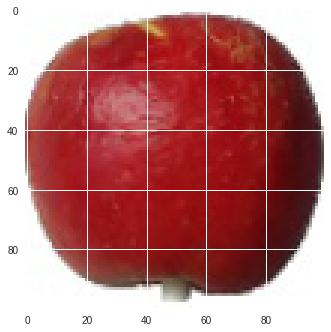

In [41]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('fruits-360/Training/Apple Red Yellow/273_100.jpg')

#サイズは、100x100のようです
print(img.size)
plt.imshow(img)
plt.show()

複数の画像を表示する

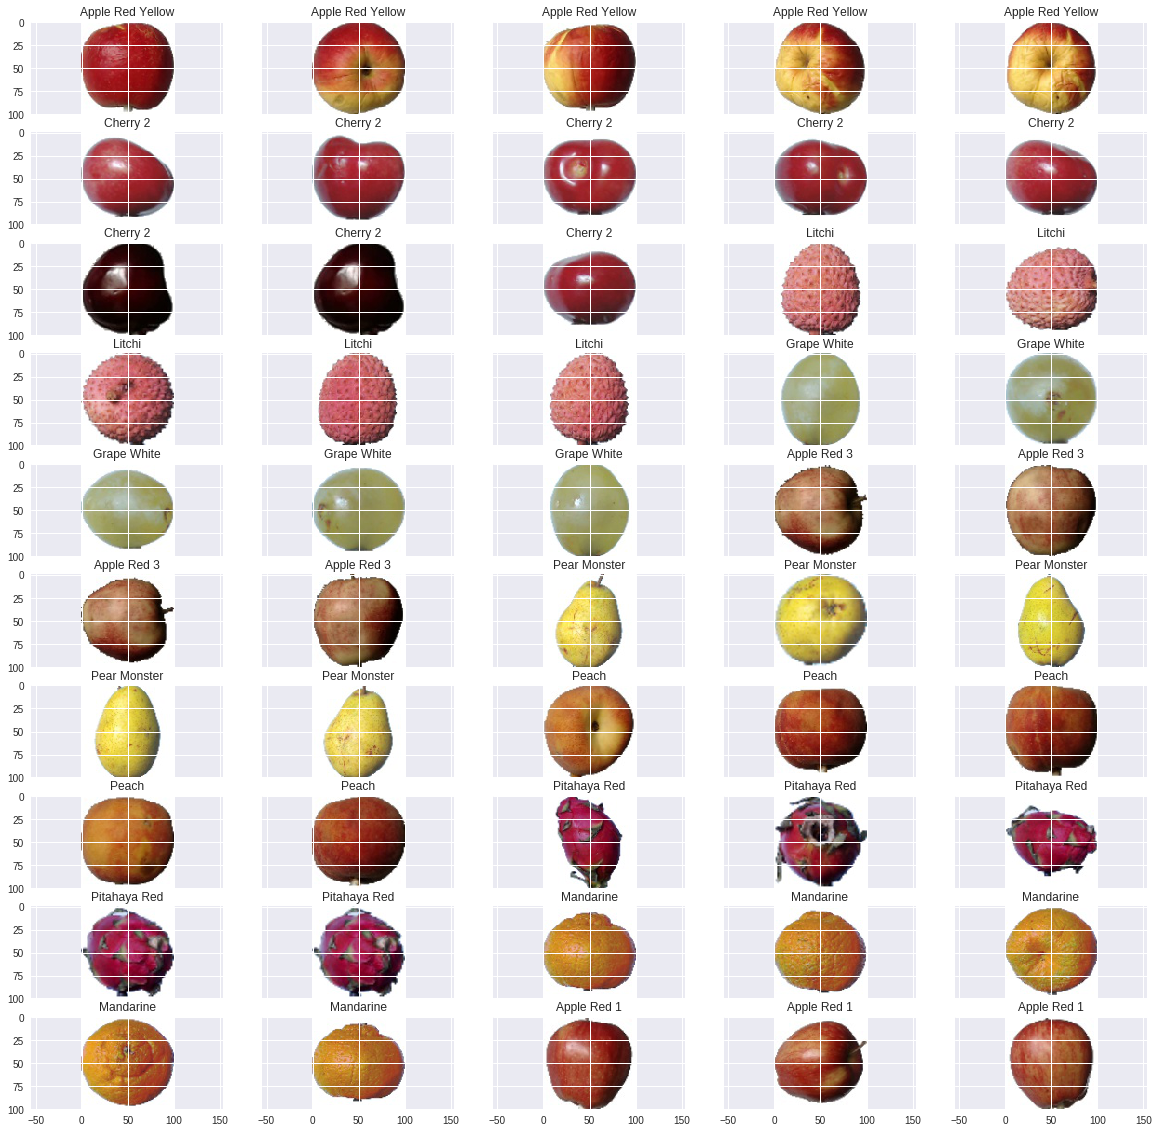

In [44]:
#画像のパスをすべて取得する
img_path_list = glob.glob("fruits-360/**/*.jpg", recursive=True)

#figsizeで大きさを指定できます
fig,ax = plt.subplots(nrows=10,ncols=5, sharex=True, sharey=True,figsize=(20, 20))

#一次元で扱えるようにする
ax = ax.flatten()

for i in range(50):
  #100掛けて、適当に表示
  img_path = img_path_list[i * 100]
  img = Image.open(img_path)
  #ファイル名を表示する
  name = img_path.split('/')[2]
  ax[i].set_title(name)
  ax[i].imshow(img)
  

##Chainerをインストールします

chainerをインストールします。
GPUを使うので、cupy-cuda80もインストールします。

In [202]:
!pip uninstall chainer -y
!pip uninstall cupy-cuda80 -y
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install 'chainer==4.0.0b4' 'cupy-cuda80==4.0.0b4'
!pip install chainer -U
!pip install cupy-cuda80 -U

Uninstalling chainer-4.1.0:
  Successfully uninstalled chainer-4.1.0
Uninstalling cupy-cuda80-4.1.0:
  Successfully uninstalled cupy-cuda80-4.1.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 1s (16.5 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack ...

    100% |████████████████████████████████| 205.4MB 88kB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/89/2e/12/fe6441d846a967c24ded700e140bc2a71f56044199b72f33dc
Successfully built chainer
Requirement not upgraded as not directly required: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from chainer) (1.11.0)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from chainer) (1.14.3)
Requirement not upgraded as not directly required: filelock in /usr/local/lib/python3.6/dist-packages (from chainer) (3.0.4)
Requirement not upgraded as not directly required: protobuf>=3.0.0 in /usr/local/lib/python3.6/dist-packages (from chainer) (3.5.2.post1)
Requirement not upgraded as not directly required: setuptools in /usr/local/lib/python3.6/dist-packages (from protobuf>=3.0.0->chainer) (39.2.0)
  Found existing installation: chainer 4.0.0b4
    Uninstalling c

GPUが有効になっていることを確認する

In [1]:
import chainer
import cupy
chainer.print_runtime_info()
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

Chainer: 4.1.0
NumPy: 1.14.3
CuPy:
  CuPy Version          : 4.1.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2104
GPU availability: True
cuDNN availablility: True


##Chainer用のデータセットを作る

[LabeledImageDataset](https://github.com/chainer/chainer/blob/v4.1.0/chainer/datasets/image_dataset.py)を利用して、データセットを作ります。


「画像のパス、正解ラベル(int型)をタプル」の配列または、
「画像パス,正解ラベル 」のファイルとする必要があります。

「画像パス,正解ラベル 」のファイルの場合、
ディレクトリ名に空白があるとダメっぽいので、
「画像のパス、正解ラベル(int型)をタプル」の配列でやります。

正解ラベルの配列を作る

In [21]:
import os
#これで重複なく、ラベルとなるディレクトリが取れます。
IMG_LABLEL_PATH = './fruits-360/Training/'
label_path_list = [x for x in os.listdir(IMG_LABLEL_PATH) if os.path.isdir(os.path.join(IMG_LABLEL_PATH, x))]

#ラベルの件数を確認します
print(len(label_path_list))

#10件表示してみます
_  = [print(x) for x in label_path_list[:10]]

65
Apple Red Yellow
Cherry 2
Litchi
Grape White
Apple Red 3
Pear Monster
Peach
Pitahaya Red
Mandarine
Apple Red 1


「画像のパス、正解ラベル(int型)をタプル」の配列でデータセットを作ります。

In [3]:
def get_path_and_label_index(img_path):
  #ディレクトリ名を取得します。
  full_directri_name = os.path.dirname(img_path)
  directri_name = os.path.basename(full_directri_name)
  label_index = label_path_list.index(directri_name)
  return (img_path, label_index)

get_path_and_label_index('fruits-360/Training/Apple Red Yellow/273_100.jpg')

('fruits-360/Training/Apple Red Yellow/273_100.jpg', 0)

In [5]:
import glob
#学習、検証の画像パスから、画像パス、ラベルの配列を作ります
train_img_path_and_label_list = [get_path_and_label_index(x) for x in glob.glob('fruits-360/Training/**/*.jpg')]
varid_img_path_and_label_list = [get_path_and_label_index(x) for x in  glob.glob('fruits-360/Validation/**/*.jpg')]

#サイズを確認します。
print(len(train_img_path_and_label_list))
print(len(varid_img_path_and_label_list))

#３件表示してみます
print(train_img_path_and_label_list[3])
print(train_img_path_and_label_list[1000])
print(varid_img_path_and_label_list[10000])

32426
10903
('fruits-360/Training/Apple Red Yellow/r_168_100.jpg', 0)
('fruits-360/Training/Cherry 2/r_267_100.jpg', 1)
('fruits-360/Validation/Lemon/r_20_100.jpg', 59)


[LabeledImageDataset](https://github.com/chainer/chainer/blob/v4.1.0/chainer/datasets/image_dataset.py)の中では、以下の感じでデータ取得するっぽいので、通るか確認します。

In [0]:
_, _ = train_img_path_and_label_list[3]

データセットを作ります

In [0]:
from chainer.datasets import LabeledImageDataset,TransformDataset
train_datasets = LabeledImageDataset(train_img_path_and_label_list)
valid_datasets = LabeledImageDataset(varid_img_path_and_label_list) 

In [9]:
#データが取れるか確認します。
#get_exampleで、引数のインデックスのデータが取れます
train_datasets.get_example(0)

(array([[[249., 251., 253., ..., 255., 255., 255.],
         [251., 253., 253., ..., 255., 255., 255.],
         [254., 254., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [254., 254., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]],
 
        [[249., 252., 252., ..., 255., 255., 255.],
         [252., 252., 252., ..., 255., 255., 255.],
         [252., 252., 255., ..., 255., 255., 255.],
         ...,
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.],
         [255., 255., 255., ..., 255., 255., 255.]]], dtype=float32)

TransformDatasetを使って、画像を正規化します。
TransformDatasetにすると、データを取得する際に、変換メソッドを通してくれます。

In [0]:
import numpy as np
# 変換に使う処理
def transform(inputs):
  img, label = inputs
  img = img[:3, ...]
  #正規化する
  img = img / 255
  img = img.astype(np.float32)
  return img, label

In [0]:
# 変換付きデータセットにする
tarin_td = TransformDataset(train_datasets, transform)
valid_td = TransformDataset(valid_datasets, transform)

In [62]:
#変換済みのデータが取れるか確認します。
tarin_td.get_example(0)

(array([[[0.9764706 , 0.9843137 , 0.99215686, ..., 1.        ,
          1.        , 1.        ],
         [0.9843137 , 0.99215686, 0.99215686, ..., 1.        ,
          1.        , 1.        ],
         [0.99607843, 0.99607843, 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ]],
 
        [[1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.        ],
         [0.99607843, 0.99607843, 1.        , ..., 1.        ,
          1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        , ..., 1.        ,
          1.        , 1.

SubDatasetを利用して、学習データセットをランダムに並び替えます。

train、validを分ける必要ない場合も、datasets.split_dataset_random使うべきでしょうか。。。

In [0]:
from chainer.datasets import SubDataset
train_rtd = SubDataset(tarin_td, 0, len(tarin_td), np.random.RandomState(10).permutation(len(tarin_td)))

並び変わったか確認します。

In [64]:
train_rtd.get_example(0)

(array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 array(47, dtype=int32))

##学習します

In [0]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Sequential,training,iterators, optimizers
from functools import partial
from chainer.training import Trainer,extensions

In [0]:
batchsize = 128
max_epoch = 5
gpu_id = 0

In [0]:
model = Sequential(
    L.Convolution2D(None, 64, 3, 1, 1),
    L.BatchNormalization(64),
    F.leaky_relu,
    partial(F.max_pooling_2d, ksize=2, stride=2 ),
    L.Convolution2D(None, 128, 3, 1, 1),
    L.BatchNormalization(128),
    F.leaky_relu,
    partial(F.max_pooling_2d, ksize=2, stride=2 ),
    L.Convolution2D(None, 128, 3, 1, 1),
    L.BatchNormalization(128),
    F.leaky_relu,
    partial(F.max_pooling_2d, ksize=2, stride=2 ),
    L.Linear(None, 4000),
    F.leaky_relu,
    L.Linear(None, 65),
    F.leaky_relu,
)

In [68]:
model = L.Classifier(model, lossfun=F.softmax_cross_entropy, accfun=F.accuracy)
model.to_gpu(gpu_id)

In [0]:
train_iter = iterators.MultiprocessIterator(train_rtd, batchsize)
valid_iter = iterators.MultiprocessIterator(valid_td, batchsize, False, False)

In [0]:
optimaizer = optimizers.Adam().setup(model)
updater = training.StandardUpdater(train_iter, optimaizer, device=gpu_id)
trainer = Trainer(updater, stop_trigger=(max_epoch, 'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.dump_graph('main/loss'))

In [0]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
     total [..................................................]  0.99%
this epoch [####..............................................]  9.87%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [..................................................]  1.97%
this epoch [#########.........................................] 19.74%
       200 iter, 0 epoch / 10 epochs
    8.8989 iters/sec. Estimated time to finish: 0:18:36.216895.
     total [#.................................................]  2.96%
this epoch [##############....................................] 29.61%
       300 iter, 0 epoch / 10 epochs
    8.8904 iters/sec. Estimated time to finish: 0:18:26.039186.
     total [#.................................................]  3.95%
this epoch [###################...............................] 39.47%
       400 iter, 0 epoch / 10 epochs
    8.8859 it

     total [#############.....................................] 26.65%
this epoch [#################################.................] 66.45%
      2700 iter, 2 epoch / 10 epochs
    6.1448 iters/sec. Estimated time to finish: 0:20:09.660467.
     total [#############.....................................] 27.63%
this epoch [######################################............] 76.32%
      2800 iter, 2 epoch / 10 epochs
    6.2156 iters/sec. Estimated time to finish: 0:19:39.796919.
     total [##############....................................] 28.62%
this epoch [###########################################.......] 86.19%
      2900 iter, 2 epoch / 10 epochs
    6.2828 iters/sec. Estimated time to finish: 0:19:11.259802.
     total [##############....................................] 29.61%
this epoch [################################################..] 96.06%
      3000 iter, 2 epoch / 10 epochs
    6.3466 iters/sec. Estimated time to finish: 0:18:43.921212.
3           0.161943    0.97